# Introduction to *HyperSpy*, *LumiSpy* and *eXSpy*

> **Spectroscopy Data Analysis in Python Using [HyperSpy](https://hyperspy.org)**

Tutorial for the **eBEAM2024 school on nano-optics with free electrons**

> Aussois, September 1-13, 2024

**Table of Contents:**

- [Import packages](#Import-packages)
- [Loading files](#Loading-files)
- [Data structure / Axes handling](#Data-structure-/-Axes-handling)
- [Metadata](#Metadata)
- [Plot / Explore](#Plot-/-Explore)
- [Indexing](#Indexing)
- [Correction of spectral defects](#Correction-of-spectral-defects)
- [Basic model fitting](#Basic-model-fitting)
- [Peak identification / Centroid / Peak width](#Peak-identification-/-Centroid-/-Peak-width)
- [Axes types / Convert to energy scale](#Axes-types-/-Convert-to-energy-scale)
- [Model fitting](#Model-fitting)
- [Advanced fitting example](#Advanced-fitting-example)

## Import packages

We import the public functions (api = application programming interface) of `HyperSpy`.

Some functionalities of `LumiSpy` are directly available if the package is installed, but we can separately load it to access extra utilities.

Finally, `matplotlib.pyplot` provides some additional plotting functions and `numpy` numerical operations on arrays that we will use:

In [1]:
# silence some "WARNINGS" (only distracting at this stage)
import warnings; warnings.simplefilter('ignore')

# Use '%matplotlib widget' in JupterLab and '%matplotlib notebook' in JupyterNotebook for interactive inline functionality (e.g. on binder)
# For pop-up window plots on your local computer, use '%matplotlib tk' or '%matplotlib qt' instead
%matplotlib widget

import hyperspy.api as hs
import lumispy as lum
import matplotlib.pyplot as plt
import numpy as np

# Plot multiple inline figures side-by-side horizontally 
hs.preferences.Plot.widget_plot_style = 'horizontal'

**LumiSpy** and **eXSpy** provide dedicated signal classes.

We can check the **available signal types**:

In [ ]:
hs.print_known_signal_types()

## Loading files

For saving analyses, HyperSpy has its own hdf5-based data format `.hspy`.

**RosettaSciIO** provides support for a wide range of microscopy (and spectroscopy) related **data file types**!

We will load three files that we will use during the demo. A preprocessed dataset saved in the `hspy` format and two maps in the `dm4` (Gatan) format:

*We assume the file location as in the demo repository, if you downloaded the notebook and the data files individually, you might need to adapt the path.*

*You can also leave the path empty. A pop-up window will appear to select.*

In [2]:
cl1 = hs.load("../demo-files/01/01_demo.hspy")
cl2 = hs.load("../demo-files/load_from_GatanFiles/asymmetric-peak_map.dm4")
cl3 = hs.load("../demo-files/load_from_GatanFiles/quantum-emitters_map.dm4")

To see **parameters** that the function takes, in Jupyter, you can **display the docstring** by using a `?`:

In [ ]:
hs.load?

## Data structure / Axes handling

Each HyperSpy signal object has certain attributes that contain the relevant data about the axes, data and metadata.

To understand the HyperSpy datastructure, lets have a look at the dataset `cl2` (Gatan file).

As **LumiSpy** is installed, the dataset is directly recognized as CL data and the `signal_type` set to `CLSpectrum`. (The fallback would be the more generic `Signal1D` if LumiSpy is not installed).

The **signal class** provides certain specific routines, for example conversion to energy axis in the case of luminescence data.

Our sample dataset has **two navigation dimensions** and **one signal (spectral) dimension**:

In [ ]:
cl2

The information about the axes is stored in the `axes_manager`. Thus, we can get more details about the different axes, by calling the **axes manager**:

In [ ]:
cl2.axes_manager

The **actual data** (signal intensity) is stored in a numpy array:

In [ ]:
cl2.data

## Metadata

For most supported file formats, the metadata is automatically parsed into **HyperSpy's metadata tree**.
It contains information about the measurement, but potentially also about post-processing:

In [ ]:
cl2.metadata

In a separate tree, the **complete metadata from the vendor format** is read in (which follows different conventions depending on the format):

In [ ]:
cl2.original_metadata

## Plot / Explore

We can easily plot and explore the hyperspectral data (drag the marker in the *navigation* window to change the displayed spectrum):

*(In the following, we will use the preprocessed dataset `cl1`. The sample contains MethylammoniumLead Bromine (MAPbBr3) perovskite single crystals fabricated by Alice Dearle.)*

In [ ]:
cl1.plot()

Plot the **average CL spectrum** of the whole map:

In [ ]:
cl1.mean().plot()

## Indexing

HyperSpy has a powerful numpy (Matlab) style indexing mechanism that distinguishes between navigation and signal axes:

- `.inav[x1:x2,y1:y2]`
- `.isig[s1:s2]`

The index parameters can be either:
- Integer: Index in the axis array
- Float: Value in calibrated axis units

For example, we can either plot a subset of the map in navigation space (selected using pixels as index):

In [ ]:
cl1.inav[2:23,0:20].plot()

Or, we can plot the mean spectrum in a certain spectral range (selected using wavelength units):

In [ ]:
cl1.isig[440.:600.].mean().plot()

### Chromatic imaging:

Indexing can also be used for color-filtered (chromatic) imaging.

First, lets plot the **panchromatic image**:

*(the object is transposed, so that we plot the intensity over navigation instead of signal dimensions)*

In [ ]:
cl1.T.mean().plot(cmap='viridis')

Now, we can **plot the intensity in a selected spectral window** (color-filtered image) using indexing:

In [ ]:
cl1.isig[480.:550.].T.mean().plot(cmap='viridis')

Alternatively, we can interactively select a spectral window (color-filtered image) using regions of interest:

In [ ]:
im = cl1.T
im.plot()
roi1 = hs.roi.SpanROI(left=455, right=485) #sets a digitalbandfilter
im_roi1 = roi1.interactive(im, color="red")
im_roi1_mean = hs.interactive(im_roi1.mean,
                          event=roi1.events.changed,
                          recompute_out_event=None)
im_roi1_mean.plot(cmap='viridis')

## Correction of spectral defects

Working on the unprocessed dataset `cl2`, we can introduce some basic functions for artefact correction:

### Remove background (interactive)

HyperSpy has an interactive tool for **background removal** that supports various functions, let's start by removing a **simple offset**:
1. Select a region to be used to determine the background (lowest signal intensity): On the signal plot click, drag and release
2. Select the background type *Offset* (can also be set using the argument `background_type="Offset"`)
3. You can still move the region or its boundaries with the mouse and inspect the different spectra using the navigator to make sure the region is right
4. Press `Apply`

In [3]:
cl2.plot()
cl2.remove_background(background_type="Offset")

The module://ipympl.backend_nbagg matplotlib backend is not compatible with the traitsui GUI elements. For more information, read http://hyperspy.readthedocs.io/en/stable/user_guide/getting_started.html#possible-warnings-when-importing-hyperspy.


### Remove last pixels from the spectrum

The signal beyond 800 nm goes to negative values, so lets remove the last three pixels from every spectrum (using signal indexation) and replace the original signal.

*NOTE: Indexation operates on pixel in the signal dimension if the given number is an integer and on the calibrated (wavelength axis) if a float value is used as index.*

In [4]:
cl2 = cl2.isig[:-3]

In [ ]:
cl2.plot()

### Remove spikes (interactive)

There is also a tool for interactive removal of cosmic rays (pixels with sharp spikes), see `Help` for instructions.

In brief:
- Inspect the derivative histogram
- Set a sensible threshold to catch the outliers in the histogram (8 is a sensible threshold for this dataset)
- Iterate through `Find next` / `Remove spike` to continue for wrong identifications / remove identified spikes
- `Close` when finished

*NOTE: The interactive version does not work well with inline plotting. You can also do an automatic best guess spikes removal by passing `interactive=False`.*

In [5]:
cl2.spikes_removal_tool(interactive=False)

WARNING | Hyperspy | Estimated number of bins using `bins='fd'` is too large (3984). Capping the number of bins at `max_num_bins=1000`. Consider using an alternative method for calculating the bins such as `bins='scott'`, or increasing the value of the `max_num_bins` keyword argument. (hyperspy.misc.hist_tools:97)


### Data smoothing

The current dataset is quite noisy. As the peak is broad in comparison with the spectral resolution, one way to improve that is by **rebinning** the data along the signal axis:

In [6]:
cl2 = cl2.rebin(scale=[1,1,2])
cl2.plot()

Additionally, HyperSpy provides three different functions for **data smoothing**:

- `smooth_lowess` (lowess smoothing)
- `smooth_savitzky_golay` (Savitzky Golay filter)
- `smooth_tv` (total variation data smoothing)

These functions can be run interactively to choose the right parameters, but the parameters can also be passed to the function. You can play with the parameters and get a live preview, and hit `Apply` when you are happy with the smoothed curve.

*As we want to use the non-smoothed data afterwards for fitting the data, we first make a copy of the dataset.*

In [7]:
cl2a = cl2.deepcopy()
cl2.plot()
cl2.smooth_lowess(number_of_iterations = 2)

[                                        ] | 0% Completed | 1.01 s ms

In [ ]:
cl2.plot()

## Basic model fitting

We will start by introducing very basic fitting functionality. A more elaborate example on [model fitting](#Model-fitting) will follow later in this notebook. For more details see also the [HyperSpy demos repository](https://github.com/hyperspy/hyperspy-demos).

*Note that for simplicity, we do the fitting in the wavelength domain. In particular for luminescence spectroscopy data containing broad emission bands, it might make more sense to run these routines in the [energy domain](#Axes-types-/-Convert-to-energy-scale) after a [Jacobian transformation](#Jacobian-transformation) instead of converting the result. An example is included later in this notebook.*

First, we need to **initialize the model** (using the unsmoothed data):

In [ ]:
m = cl2a.create_model()

A HyperSpy model can be composed of several **components** (functions).

We can **check the components** of the model – should be empty, but for some types of signals like EDS and EELS, the model is automatically initialized with components:

In [ ]:
m.components

Thus, we need to **create some components** and **add them to the model**.

As the emission peak in our dataset is rather asymmetric, we will use a single `SkewNormal` component.

*Note that HyperSpy has a range of [built-in functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html#pre-defined-model-components) covering most needs that can be added as components to a model. However, it also has an intuitive mechanism to [define custom functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html#define-components-from-a-mathematical-expression).*

In [ ]:
g1 = hs.model.components1D.SkewNormal()
m.append(g1) # m.extend([g1,g2])
m.components

To see the parameters of our components and their default values, we can **print all parameter values**:

In [ ]:
m.print_current_values()

To apply the fit to all the spectra in the map, we use the `multifit` command.

In the current case of a single, well defined peak, we achieve a good fit without adjusting the initial values of the parameters or setting any boundaries.

In [ ]:
m.multifit()

We can now **plot the model** together with the data:

In [ ]:
m.plot()

The `SkewNormal` component represents the asymmetry of the peak very well, but does not fully reproduce the height of the main part of the peak.

We can also print the parameter values at the current index:

In [ ]:
m.print_current_values()

## Peak identification / Centroid / Peak width

In particular for asymmetric peaks, fitting might not always be the best way to determine peak characteristics (despite asymmetric functions, such as the skew normal distribution, being provided). Therefore, HyperSpy provides a number of additional routines.

Peaks can be identified and characterized using the **peak finder** routine `find_peaks1D_ohaver` that is based on the downwards zero crossing of the first derivative.

*For these routines, it is helpful to operate on the smoothed dataset. As we have some side-peaks, we operate on a subrange of the wavelength axis defined by `isig`.*

In [8]:
peaks = cl2.isig[600.:].find_peaks1D_ohaver(maxpeakn=1)

[########################################] | 100% Completed | 316.48 ms


The function **returns a structured array** that contains `position`, `height` and `width` for every pixel (potentially each for multiple peaks).

In [9]:
peaks[0,0]

array([(668.28143038, 4.69351985, 95.84059918)],
      dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')])

Especially for broad, asymmetric emission bands, the position of the maximum intensity might be of limited value. Therefore, **LumiSpy** provides an additional `centroid` function that determines the **centre of mass** of a peak.

Required version: lumispy>=0.2.2

*Note that, as with fitting, it might make more sense to run these routines in the [energy domain](#Axes-types-/-Convert-to-energy-scale) after a [Jacobian transformation](#Jacobian-transformation) than to convert the result - in particular for broad emission bands. For simplicity, we introduce it in the wavelength domain.*

In [10]:
com = cl2.isig[600.:].centroid()

[########################################] | 100% Completed | 101.31 ms


The result is a new `signal` that we can plot as a colormap using the HyperSpy functionality:

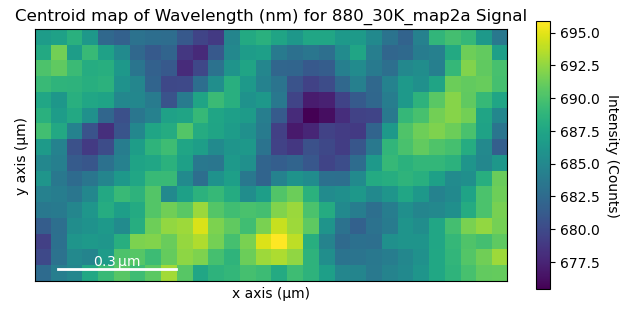

In [11]:
com.plot(cmap='viridis')

You can also determine the **width of a peak** directly from the signal without fitting a model to the data. Again useful for asymmetric peaks. To plot the FWHM interval, we set `return_interval=True` (the returned list then contains three arrays: *width*, as well as *left position* and *right position* of the interval). 

The default is to determine the **FWHM**, i.e. a `factor=0.5`. This value can be set to any other fraction of the peak height.

In [12]:
width = cl2.isig[600.:].estimate_peak_width(return_interval=True)

[########################################] | 100% Completed | 101.93 ms


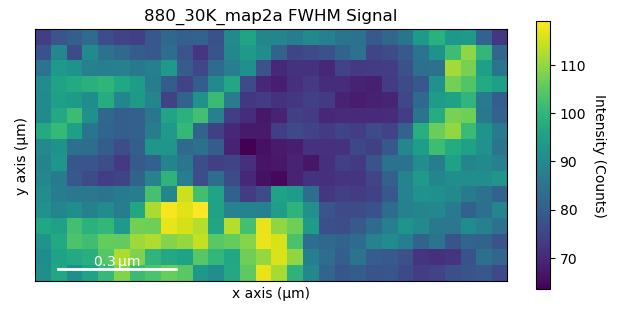

In [13]:
width[0].plot(cmap='viridis')

Now we can **add markers** for the *FWHM interval* and the *centre of mass* to the signal object and plot them on the spectra:

In [28]:
# Temporary fix as with the HyperSpy 2.0 release, the signals used to create markers need to be of `ragged` type
def to_ragged(s):
    s2 = hs.signals.BaseSignal(np.empty(s.T.axes_manager.navigation_shape[::-1], dtype=object), ragged=True)
    for indices in np.ndindex(s2.data.shape):
        s2.data[indices] = np.array([s.data[indices]])
    return s2

In [24]:
width[1].T.axes_manager.navigation_shape[::-1]

(16, 30)

In [29]:
mrk = hs.plot.markers.VerticalLines.from_signal(to_ragged(com), color='black', signal_axes=None)
mrkl = hs.plot.markers.VerticalLines.from_signal(to_ragged(width[1]), color='grey', signal_axes=None)
mrkr = hs.plot.markers.VerticalLines.from_signal(to_ragged(width[2]), color='grey', signal_axes=None)
cl2.add_marker([mrk,mrkl,mrkr], permanent=True)
cl2.plot()

In [30]:
mrk = hs.plot.markers.VerticalLines.from_signal(com.T, color='black', signal_axes=None)
mrkl = hs.plot.markers.VerticalLines.from_signal(width[1].T, color='grey', signal_axes=None)
mrkr = hs.plot.markers.VerticalLines.from_signal(width[2].T, color='grey', signal_axes=None)
cl2.add_marker([mrk,mrkl,mrkr], permanent=True)
cl2.plot()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (16, 2, 2) + inhomogeneous part.

## Axes types / Convert to energy scale

*(Required versions: hyperspy>=1.7.0 and lumispy>=0.2.0)*

HyperSpy has different types of axes:
- The standard `UniformDataAxis` is defined through an `offset` and a `scale` (delta between pixels)
- A `FunctionalDataAxis` is defined through a `UniformDataAxis` and a `function` to convert the values
- A more general `DataAxis` is defined through an `axis` vector/array

The *wavelength* scale of our sample object is a `UniformDataAxis`:

In [ ]:
cl1.axes_manager

*LumiSpy* provides easy conversions of the signal axis to the **energy scale**:

It can either replace the axis in the existing object (default) or create a copy of the signal object with the new axis (`inplace=False`):

In [ ]:
cl1_eV = cl1.to_eV(inplace=False)

The signal axis is now a *non-uniform axis*:

In [ ]:
cl1_eV.axes_manager

This axis is defined through an axis vector:

In [ ]:
cl1_eV.axes_manager[-1].axis

To explore the data in the energy domain, we again plot the signal:

In [ ]:
cl1_eV.plot()

### Jacobian transformation

To preserve the integrated intensity per spectral window, a *Jacobian* transformation has to be applied to the signal intensity:

As we require $I(E)dE = I(\lambda)d\lambda$, the scale transformation $E=hc/\lambda$ implies

$$I(E) = I(\lambda)\frac{d\lambda}{dE} = I(\lambda)\frac{d}{dE}
\frac{h c}{E} = - I(\lambda) \frac{h c}{E^2}$$

(where the minus sign just reflects the different directions of integration in the wavelength and energy domains)

This transformation is the default in LumiSpy, but can be deactivated by setting `jacobian=False`.

To visualize the effect of the *Jacobian transformation*, we can plot a signal with constant intensity before and after the transformation:

In [ ]:
# Create a model signal with linear intensity
axis = {'offset': 300, 'scale': 4, 'units': 'nm', 'size': 101, 'name': 'Wavelength'}
s = hs.signals.Signal1D(np.ones(101), axes=[axis])
s.set_signal_type("Luminescence")
s2 = s.to_eV(inplace=False)

In [ ]:
# Some additional arrays to help with visualizing the spectral bins during plotting
x = np.arange(9)*50+300
x2 = lum.nm2eV(x)
y2 = hs.signals.Signal1D(np.ones(9), axes=[{'offset': 300, 'scale': 50, 'size': 9,}])
y2.set_signal_type("Luminescence")
y2.to_eV()

In [ ]:
# Plot comparative figures
fig1 = plt.figure(figsize=(10,4))
ax0 = plt.subplot(121)
plt.ylim(0,1.3)
plt.xlabel('Wavelength (nm)')
ax0.plot(s.axes_manager[0].axis,s.data,color='orange')
ax0.vlines(x,0,1,color='orange')
ax0.fill_between(s.axes_manager[0].axis,0,s.data, facecolor='orange', alpha=0.3)
ax1 = plt.subplot(122)
plt.ylim(0,0.43)
plt.xlabel('Energy (eV)')
ax1.plot(s2.axes_manager[0].axis,s2.data,color='orange')
ax1.vlines(x2,0,y2.data[::-1],color='orange')
ax1.fill_between(s2.axes_manager[0].axis,0,s2.data, facecolor='orange', alpha=0.3)

## Model fitting

We will introduce some extended fitting functionality using our sample dataset `cl1`, for more details see the `Fitting_tutorial` in the [HyperSpy demos repository](https://github.com/hyperspy/hyperspy-demos).

Note again that HyperSpy has a range of [built-in functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html#pre-defined-model-components) covering most needs that can be added as components to a model. However, it also has an intuitive mechanism to [define custom functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html#define-components-from-a-mathematical-expression).

First, we need to **initialize the model**:

In [ ]:
m = cl1_eV.create_model()

**Check the components** of the model:

In [ ]:
m.components

**Create some components** and **add them to the model**.

We will use a constant `Offset` and a Gaussian (defined through height and FWHM, hence `GaussianHF`):

In [ ]:
bkg = hs.model.components1D.Offset()
g1 = hs.model.components1D.GaussianHF()
m.extend([g1, bkg])
m.components

To see the parameters of our components and their default values, we can **print all parameter values**:

In [ ]:
m.print_current_values()

Lets set some **sensible starting values** for our components, for a position in the map where we know that there should be signal (as it is not the case everywhere for our sample dataset):

*Note that we could also use the estimate parameters function of the `GaussianHF` component (commented out line). However, this approach does not work as well as using manual starting values for this rather noisy dataset where many pixels do not contain spectra, unless additional boundaries are set to the parameters below.*

In [ ]:
# g1.estimate_parameters(cl1_eV,2.3,2.5)
cl1.axes_manager.indices = (7,7)
g1.centre.value = 2.4        # Gaussian centre
g1.fwhm.value = 0.1      # Gaussian width
g1.height.value = 5      # Gaussian height
bkg.offset.value = 0.1   # background offset

We can also **set boundaries** (`bmin` and `bmax`) for some of the parameters:

In [ ]:
g1.centre.bmax = g1.centre.value + 0.2
g1.centre.bmin = g1.centre.value - 0.2
g1.fwhm.bmin = 0.01

We can now **fit the model at the chosen position**, copy the result as starting value to all positions, and **plot** the result:

In [ ]:
m.fit(bounded=True)
m.assign_current_values_to_all()
m.plot()

Again, we can also **print the updated parameters**:

In [ ]:
m.print_current_values()

The model now has the result from our chosen pixel everywhere. Using this as optimized starting paramters, we can now **fit all pixels**. When plotting, we activate additional plotting of the individual components:

In [ ]:
m.multifit(bounded=True, show_progressbar=True)
m.plot(plot_components=True)

To plot maps of the parameters of the Gaussian, we create signal objects from these datasets:

In [ ]:
m_centre = g1.centre.as_signal()
m_centre.plot(cmap='bwr_r', centre_colormap=False) # Otherwise, it would be centred around `0` and we would see little difference between pixels
m_intensity = g1.height.as_signal()
m_intensity.plot(cmap='viridis')

### Particle segmentation

We can use the fit model as basis to do a particle segmentation by **creating a mask** for all pixels, where the intensity is below the mean value:

In [ ]:
mask_treshold = m_intensity.data.mean()
mask = m_intensity.data > mask_treshold #Returns a boolean matrix mask
plt.figure()
plt.imshow(mask)

We can now plot the previous graph of the centre-parametre, after applying the mask:

In [ ]:
(m_centre * mask).plot(cmap='bwr_r', vmin=2.3, centre_colormap=False) 

# TODO

- Provide zip file to download all datasets for this notebook at once.

## Basics that could be added at the start of the notebook:
- python basics? Variable types, numpy arrays, Signal object, methods (general, what are the data types you have to deal with, when using hyperspy?)

## Examples that could be added to this notebook to have enough potentially new stuff also for advanced users:
- import textfiles? molding onto BaseSignal? (necessary?)
- Getting the position of the maximum from each spectrum
- Usage of the map function
- Extracting a line profile using a ROI
- Custom component using expression
- Machine learning on the example of EELS

## Advanced fitting example

Finally, to showcase the power of fitting with a programming language, lets fit the more complicated dataset `cl3`:

1. Fit a spectrum with a skew normal component on a broad Gaussian as background.

2. Then add a variable number of sharp Gaussians depending on the number of peaks found by the peak finder routine.

*The presented dataset is a CL map of luminescent centers in h-BN on SiO$_2$, similar as discussed in Hernández-Mínguez et al., [Phys. Rev. Appl. 10, 2331](https://doi.org/10.1103/PhysRevApplied.10.044031) (2018). The analysis is simplified for instructive purposes.*

*For reasons of calculation time, we run the fit on a single spectrum, but it could of course be looped across a complete spectral map - even with a variable number of peaks per spectrum. To apply functions defined for individual spectra on a complete spectral image, HyperSpy provides the [`map` function](https://hyperspy.org/hyperspy-doc/current/user_guide/signal.html#iterating-external-functions-with-the-map-method).*

In [ ]:
cl3 = cl3.inav[10,8]
m = cl3.create_model()
g1 = hs.model.components1D.SkewNormal()
g2 = hs.model.components1D.GaussianHF()
m.extend((g1,g2))
g1.x0.value=655
g1.scale.value=50
g1.shape.value=2
g1.A.value=220
g1.x0.bmin=635
g1.x0.bmax=675
g1.x0.bounded=True
g2.centre.value=580
g2.fwhm.value=180
g2.height.value=20
m.fit()
m.plot()

In [ ]:
def getPeaks(S2):
    S2=S2.rebin(new_shape=[334])
    S2.smooth_savitzky_golay(window_length=15,polynomial_order=2)
    peaks = S2.find_peaks1D_ohaver(amp_thresh=0.2*np.max(S2.data),maxpeakn=10)[0]
    return peaks

In [ ]:
ng=10
S2 = cl3.deepcopy()
g = list()
for i in np.arange(ng):
    g.append(hs.model.components1D.GaussianHF())
m.extend(g)
for i in np.arange(ng):
    g[i].active_is_multidimensional = True
# The following code would need to be in a loop to run for a whole spectral image
# m.axes_manager.indices = cl3.axes_manager.indices
peaks = getPeaks(S2.inav[cl3.axes_manager.indices])
for i in np.arange(np.size(peaks)):
    g[i].centre.value=peaks['position'][i]
    g[i].centre.bmin=peaks['position'][i]-3
    g[i].centre.bmax=peaks['position'][i]+3
    g[i].centre.bounded=True
    g[i].fwhm.value=5
    g[i].fwhm.bmax=10
    g[i].fwhm.bmin=1
    g[i].fwhm.bounded=True
    g[i].height.value=20
    g[i].height.bmin=1
    g[i].height.bounded=True
if np.size(peaks)<ng:
    for i in np.arange(np.size(peaks),ng):
        g[i].active = False
m.fit(bounded=True)
m.plot()

## Now try with your own data!
